In [1]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import os
import torch.nn.functional as F
import numpy as np
import torch.utils.data as Data
from PIL import  Image,ImageDraw
import numpy as np
import random
import cv2
from torchvision import models
from torchsummary import summary

Batch_Size = 50
num_epochs = 200
learning_rate = 1e-5
samples = 20000

data1 = []
data2= []


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% --  Generate dataset
uframes = []
vidcap = cv2.VideoCapture('square.avi')
success,image = vidcap.read()
while success:
    uframes.append(image)   
    success,image = vidcap.read()

# cap = cv2.VideoCapture('video_drone_tank.avi')


# ret, frame = cap.read()

# uframes.append(frame)
# flag = 0
# z = 0
# while(z<30):
#     ret, frame = cap.read()
#     #np_frame = cv2.imread('video', frame) # does not work
#     #np_frame = np.asarray(cv2.GetMat(frame)) # does not work
#     #print(np_frame.shape)
#     for a in uframes:
#         if (np.array(a).any() != None):
#             print("a: ",np.shape(a))
#             print("frame: ",np.shape(a))
#             difference = cv2.subtract(np.array(a), np.array(frame))    
#             result = not np.any(difference)
#             #print("inside for")
#             if result is True:
#                 flag = 1
#                 #print("setting flag")
#                 break
#     if(not flag):
#         #print("appending")
#         uframes.append(frame)
#     z+=1

for i,frame in enumerate(uframes):
    uframes[i] = cv2.resize(frame,(100,100))
    
print(np.shape(uframes[0]))

print("length: ",len(uframes))
for i in range(samples):
    data1.append(np.array(np.transpose(np.asarray(uframes[i % len(uframes)]),(2,0,1)),dtype=np.float32))
    data2.append(np.array(np.transpose(np.asarray(uframes[(i+1) % len(uframes)]),(2,0,1)),dtype=np.float32))



#%%%%%%%%%%%%%%%%%%%%%%%%%%% Noisy data
img = Image.new('RGB', (100,100), color = '#9b7653')
# img.paste(im1,(5,75),im1)
# img.paste(im1,(10,55),im1)
# img.paste(im1,(25,50),im1)
# img.paste(im2,(75,5),im2)
# img.paste(im2,(60,30),im2)
# img.paste(im2,(90,20),im2)
# img.paste(im3,(75,60),im3)
# img.paste(im3,(60,80),im3)
im_n = np.reshape(img,(100,100,3))
b = np.asarray(im_n)
b = np.array(b, dtype=np.float32)
b = np.transpose(b,(2,0,1))
b = torch.from_numpy(b)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%       

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Data Preparation

y0 = np.asarray(data1)
y1 = np.asarray(data2)

#y0 = np.array(np.transpose(np.asarray(y0),(0,3,1,2)),dtype=np.float32)
#y1 = np.array(np.transpose(np.asarray(y1),(0,3,1,2)),dtype=np.float32)
print(np.shape(y0))

x = torch.from_numpy(y0)
y = torch.from_numpy(y1)


torch_dataset = Data.TensorDataset(x,y)


loader = Data.DataLoader(

    dataset=torch_dataset,

    batch_size=Batch_Size,

    shuffle=True,

    num_workers=0,

)


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Defining NN

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=10, stride=1)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=5)

#         # Convolution 2
#         self.cnn2 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=5, stride=1, padding=2)
#         self.relu2 = nn.ReLU()

#         # Max pool 2
#         self.maxpool2 = nn.MaxPool2d(kernel_size=5)

        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(41472, 15)
        self.sigmoid1 = nn.Sigmoid()

    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2 
        #out = self.cnn2(out)
        #out = self.relu2(out)

        # Max pool 2 
        #out = self.maxpool2(out)
        im_out = out
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        out = self.sigmoid1(out)
        return im_out,out
    
model = CNNModel()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% - Loss Function

def h_score(fx, gy):
 
    fx = fx - fx.mean(0)

    gy = gy - gy.mean(0)

    Nsamples = fx.size(0)
    #print(fx, np.shape(fx))
    #print(gy, np.shape(gy))
    #print(np.shape((torch.transpose(fx,3,2))),np.shape(fx))
    covf = torch.matmul(fx.t(), fx) / Nsamples

    covg = torch.matmul(gy.t(), gy) / Nsamples

    h = -2 * torch.mean((fx * gy).sum(1)) + (covf * covg).sum()

    return h


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-4)





for epoch in range(num_epochs):
    for x,y in loader:
        optimizer.zero_grad()
        # ===================forward=====================
        #loss = criterion(output1, img)
        loss = h_score(model(x)[1],model(y)[1])
        # ===================backward====================
 
        #optimizer_1.zero_grad()
        loss.backward()
        optimizer.step()
        #optimizer_1.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))
    #print("shape: ", np.shape(model(x[0].reshape(1,3,100, 100))[0]))
#     print("x: ", model(x[0].reshape(1,3,100, 100)))
#     print("y:", model(y[0].reshape(1,3,100, 100)))
#     print("b:", model(b.reshape(1,3,100, 100)))


(100, 100, 3)
length:  892
(20000, 3, 100, 100)
epoch [1/200], loss:-0.3358
epoch [2/200], loss:-0.3694
epoch [3/200], loss:-0.3460
epoch [4/200], loss:-0.3328
epoch [5/200], loss:-0.3322
epoch [6/200], loss:-0.3270
epoch [7/200], loss:-0.3213
epoch [8/200], loss:-0.2661
epoch [9/200], loss:-0.3492
epoch [10/200], loss:-0.3595
epoch [11/200], loss:-0.3147
epoch [12/200], loss:-0.3885
epoch [13/200], loss:-0.3967
epoch [14/200], loss:-0.2779
epoch [15/200], loss:-0.3620
epoch [16/200], loss:-0.3380
epoch [17/200], loss:-0.3105
epoch [18/200], loss:-0.4139
epoch [19/200], loss:-0.4281
epoch [20/200], loss:-0.3673
epoch [21/200], loss:-0.3520
epoch [22/200], loss:-0.3790
epoch [23/200], loss:-0.3962
epoch [24/200], loss:-0.3568
epoch [25/200], loss:-0.3259
epoch [26/200], loss:-0.3419
epoch [27/200], loss:-0.3110
epoch [28/200], loss:-0.3695
epoch [29/200], loss:-0.3517
epoch [30/200], loss:-0.3784
epoch [31/200], loss:-0.4131
epoch [32/200], loss:-0.3781
epoch [33/200], loss:-0.3773
epoc

In [7]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

drone_panels={}
tank_panels={}
tank_reloading_panels={}
drone_reloading_panels={}

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

for i in range(64):

    tank_info_panel = i
    #rone_info_panel = i
    #Blank
    img = uframes[1]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Blank: ",val,pos)
#     output_drone = output[0][drone_info_panel]
#     val,pos = val_pos(output_drone)
#     print("Blank: ",val,pos)


    print("**********")
    img = uframes[2]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val_tank_info,pos_tank_info = val_pos(output_tank)
    print("Tank: ",val_tank_info,pos_tank_info)
#     output_drone = output[0][drone_info_panel]
#     val_tank_drone_info,pos_tank_drone_info = val_pos(output_drone)
#     print("Tank: ",val,pos)
    print("**********")

    #Drone
    img = uframes[3]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val_drone_info,pos_drone_info = val_pos(output_tank)
    print("Drone: ",val_drone_info,pos_drone_info)
#     output_drone = output[0][drone_info_panel]
#     val_drone_drone_info,pos_drone_drone_info = val_pos(output_drone)
#     print("Drone: ",val,pos)
    
    print("**********")  
    img = uframes[4]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val_tank_reloading_info,pos_tank_reloading_info = val_pos(output_tank)
    print("Tank reloading: ",val_tank_reloading_info,pos_tank_reloading_info)
#     output_drone = output[0][drone_info_panel]
#     val_tank_reloading_drone_info,pos_tank_reloading_drone_info = val_pos(output_drone)
#     print("Tank reloading: ",val,pos)

    print("**********")
    #Drone Reloadingg
    img = uframes[5]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val_drone_reloading_info,pos_drone_reloading_info = val_pos(output_tank)
    print("Drone reloading: ",val_drone_reloading_info,pos_drone_reloading_info)
#     output_drone = output[0][drone_info_panel]
#     val_drone_reloading_drone_info,pos_drone_reloading_drone_info = val_pos(output_drone)
#     print("Drone reloading: ",val,pos)

    print("**********")
    #Tank and Drone
    img= uframes[0]
    z = Image.fromarray(img)
    #z.show()
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("TD: ",val,pos)
#     output_drone = output[0][drone_info_panel]
#     val,pos = val_pos(output_drone)
#     print("TD: ",val,pos)
    
    print("**********")
    #Tank and Drone reloading
    img= uframes[6]
    z = Image.fromarray(img)
    #z.show()
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("TrDr: ",val,pos)
#     output_drone = output[0][drone_info_panel]
#     val,pos = val_pos(output_drone)
#     print("TD: ",val,pos)
    
    print("\nPanel ",i)
    print("\n++++++++++++++++++++++++++++++++++++++++++++\n")
    if val_tank_info > max(val_drone_reloading_info,val_tank_reloading_info,val_drone_info):
        tank_panels[i]=val_tank_info-5
    elif val_drone_info > max(val_drone_reloading_info,val_tank_reloading_info,val_tank_info):
        drone_panels[i]=val_drone_info-5
    elif val_tank_reloading_info > max(val_drone_reloading_info,val_tank_info,val_drone_info):
        tank_reloading_panels[i]=val_tank_reloading_info-5
    elif val_drone_reloading_info > max(val_tank_reloading_info,val_tank_info,val_drone_info):
        drone_reloading_panels[i]=val_drone_reloading_info-2
print(drone_panels)

Blank:  204.03383 (3, 8)
**********
Tank:  275.51743 (5, 0)
**********
Drone:  302.40936 (13, 2)
**********
Tank reloading:  408.74387 (6, 0)
**********
Drone reloading:  353.80252 (13, 1)
**********
TD:  368.45044 (13, 2)
**********
TrDr:  558.5044 (6, 0)

Panel  0

++++++++++++++++++++++++++++++++++++++++++++

Blank:  621.0657 (11, 12)
**********
Tank:  825.75726 (5, 0)
**********
Drone:  783.81946 (11, 12)
**********
Tank reloading:  786.5104 (11, 12)
**********
Drone reloading:  942.9388 (13, 2)
**********
TD:  991.3714 (5, 0)
**********
TrDr:  1112.5355 (13, 2)

Panel  1

++++++++++++++++++++++++++++++++++++++++++++

Blank:  532.18225 (10, 3)
**********
Tank:  708.10205 (4, 0)
**********
Drone:  709.2772 (13, 2)
**********
Tank reloading:  819.9264 (5, 1)
**********
Drone reloading:  946.71454 (12, 1)
**********
TD:  882.64966 (13, 2)
**********
TrDr:  1235.1675 (12, 1)

Panel  2

++++++++++++++++++++++++++++++++++++++++++++

Blank:  1550.1617 (11, 13)
**********
Tank:  1856.2684 

Tank reloading:  905.5575 (5, 0)
**********
Drone reloading:  760.3207 (12, 1)
**********
TD:  736.62305 (13, 2)
**********
TrDr:  1104.3716 (5, 0)

Panel  28

++++++++++++++++++++++++++++++++++++++++++++

Blank:  867.05756 (11, 2)
**********
Tank:  1025.7855 (6, 1)
**********
Drone:  1066.3704 (12, 2)
**********
Tank reloading:  1199.4508 (5, 0)
**********
Drone reloading:  932.2317 (11, 2)
**********
TD:  1214.5151 (12, 2)
**********
TrDr:  1265.6189 (5, 0)

Panel  29

++++++++++++++++++++++++++++++++++++++++++++

Blank:  509.669 (8, 8)
**********
Tank:  671.35376 (5, 0)
**********
Drone:  694.0139 (13, 2)
**********
Tank reloading:  681.2836 (5, 0)
**********
Drone reloading:  732.1422 (13, 2)
**********
TD:  846.85254 (13, 2)
**********
TrDr:  905.42584 (5, 0)

Panel  30

++++++++++++++++++++++++++++++++++++++++++++

Blank:  515.5486 (16, 14)
**********
Tank:  849.7809 (5, 1)
**********
Drone:  798.2815 (13, 2)
**********
Tank reloading:  916.947 (5, 0)
**********
Drone reloading: 

Drone:  270.58124 (12, 1)
**********
Tank reloading:  190.216 (4, 0)
**********
Drone reloading:  599.9236 (13, 1)
**********
TD:  456.68768 (5, 1)
**********
TrDr:  667.16626 (13, 1)

Panel  56

++++++++++++++++++++++++++++++++++++++++++++

Blank:  363.07184 (10, 13)
**********
Tank:  683.4309 (5, 1)
**********
Drone:  569.6821 (12, 2)
**********
Tank reloading:  552.3611 (5, 0)
**********
Drone reloading:  854.79785 (13, 2)
**********
TD:  893.2044 (5, 1)
**********
TrDr:  1046.687 (13, 2)

Panel  57

++++++++++++++++++++++++++++++++++++++++++++

Blank:  826.6097 (2, 7)
**********
Tank:  951.51996 (2, 7)
**********
Drone:  1041.1196 (13, 2)
**********
Tank reloading:  1198.1492 (5, 1)
**********
Drone reloading:  1060.1174 (12, 2)
**********
TD:  1168.9259 (13, 2)
**********
TrDr:  1431.7612 (5, 1)

Panel  58

++++++++++++++++++++++++++++++++++++++++++++

Blank:  2444.7593 (16, 14)
**********
Tank:  2871.9834 (5, 0)
**********
Drone:  2880.4773 (13, 1)
**********
Tank reloading:  267

In [5]:
for i in range(7):
    img = uframes[i]
    z = Image.fromarray(img)
    z.show()

In [6]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

for j in range(len(list(tank_reloading_panels))):
    
    tank_info_panel = list(tank_panels)[0]
    drone_info_panel = list(drone_panels)[0]
    tankr_info_panel = list(tank_reloading_panels)[j]
    droner_info_panel = list(drone_reloading_panels)[0] #12

    #print(tankr_info_panel,tank_reloading_panels[tankr_info_panel])

    tank_threshold= tank_panels[tank_info_panel]
    tankr_threshold= tank_reloading_panels[tankr_info_panel]
    drone_threshold= drone_panels[drone_info_panel]
    droner_threshold= drone_reloading_panels[droner_info_panel]

    def val_pos(array):
        value = np.sum(array)
        position = np.unravel_index(np.argmax(array),array.shape)
        return value,position
    dronec=[]
    tankc=[]
    tankr=[]
    droner=[]
    #Blank
    for i in range(50):
        #x = cv2.imread(r"C:\Users\darshan19\Desktop\AoI\CNN\Images1\0b.png",-1)
        #x = cv2.resize(x,(100,100))
        img = uframes[i]
        #print(np.shape(img))
        # = Image.fromarray(img)
        #z.show()
        data3=[]
        data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
        y3 = np.array(data3)
        x_1 = torch.from_numpy(y3)
        #print(np.shape(x_1))
        output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()
        output_tank = output[0][tank_info_panel]
        val_tank,pos_tank = val_pos(output_tank)
        output_tankr = output[0][tankr_info_panel]
        val_tankr,pos_tankr = val_pos(output_tankr)
        print(i)
        output_drone = output[0][drone_info_panel]
        val_drone,pos_drone = val_pos(output_drone)
        output_droner = output[0][droner_info_panel]
        val_droner,pos_droner = val_pos(output_droner)

        if val_tank>tank_threshold:
    #         print("tank present")
    #         print("Tank info: ",val_tank,pos_tank)
            tankc.append(pos_tank)
        if val_drone>drone_threshold:
    #         print("drone present")
    #         print("Drone info: ",val_drone,pos_drone)
            dronec.append(pos_drone)
        if val_tankr>tankr_threshold:
            print("tank reloading present")
            print("Tank info: ",val_tank,pos_tank)
            tankr.append(pos_tankr)
        if val_droner>droner_threshold:
#             print("drone reloading present")
#             print("Drone info: ",val_droner,pos_droner)
            dronec.append(pos_drone)
    print("\n")
    print(list(tank_reloading_panels)[j])
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++\n\n")


IndexError: list index out of range

In [127]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


tank_info_panel = 26#list(tank_panels)[2]
drone_info_panel = 33#list(drone_panels)[1]
tankr_info_panel = 21#list(tank_reloading_panels)[4]
droner_info_panel = 17#list(drone_reloading_panels)[12]

#print(drone_info_panel,drone_panels[drone_info_panel])

tank_threshold= tank_panels[tank_info_panel]
tankr_threshold= tank_reloading_panels[tankr_info_panel]
drone_threshold= drone_panels[drone_info_panel]
droner_threshold= drone_reloading_panels[droner_info_panel]

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position
dronec=[]
tankc=[]
tankr=[]
droner=[]
#Blank
print(len(uframes))
for i in range(200):
    #x = cv2.imread(r"C:\Users\darshan19\Desktop\AoI\CNN\Images1\0b.png",-1)
    #x = cv2.resize(x,(100,100))
    img = uframes[i]
    #print(np.shape(img))
    # = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    #print(np.shape(x_1))
    output = model(x_1.reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val_tank,pos_tank = val_pos(output_tank)
    output_tankr = output[0][tankr_info_panel]
    val_tankr,pos_tankr = val_pos(output_tankr)
    print(i)
    output_drone = output[0][drone_info_panel]
    val_drone,pos_drone = val_pos(output_drone)
    output_droner = output[0][droner_info_panel]
    val_droner,pos_droner = val_pos(output_droner)
    
    if val_tank>tank_threshold:
        print("tank present")
        print("Tank info: ",val_tank,pos_tank)
        tankc.append(pos_tank)
    if val_drone>drone_threshold:
        print("drone present")
        print("Drone info: ",val_drone,pos_drone)
        dronec.append(pos_drone)
    if val_tankr>tankr_threshold:
        print("tank reloading present")
        print("Tank info: ",val_tank,pos_tank)
        tankr.append(pos_tankr)
    if val_droner>droner_threshold:
        print("drone reloading present")
        print("Drone info: ",val_droner,pos_droner)
        droner.append(pos_drone)
    print("\n")
    print("******************************************************************************")
    print("\n")

264
0
tank present
Tank info:  1245.4308 (5, 1)
drone present
Drone info:  295.93127 (5, 0)


******************************************************************************


1


******************************************************************************


2
tank present
Tank info:  1003.29895 (5, 1)


******************************************************************************


3
drone present
Drone info:  186.09573 (11, 9)


******************************************************************************


4
tank reloading present
Tank info:  635.6013 (4, 0)


******************************************************************************


5
drone reloading present
Drone info:  136.94676 (11, 9)


******************************************************************************


6
tank reloading present
Tank info:  885.4109 (10, 9)
drone reloading present
Drone info:  214.86533 (5, 1)


******************************************************************************


7
tank present


Tank info:  1198.8966 (5, 7)
drone present
Drone info:  258.15155 (4, 7)


******************************************************************************


62
tank reloading present
Tank info:  727.06915 (4, 6)


******************************************************************************


63
drone reloading present
Drone info:  147.94095 (11, 4)


******************************************************************************


64
drone present
Drone info:  196.1532 (10, 4)
tank reloading present
Tank info:  955.8152 (10, 4)
drone reloading present
Drone info:  220.1011 (11, 4)


******************************************************************************


65
tank present
Tank info:  1155.4421 (5, 7)
drone present
Drone info:  354.51794 (10, 4)


******************************************************************************


66
tank present
Tank info:  1339.1946 (5, 7)
drone present
Drone info:  269.20786 (9, 6)


*****************************************************************

120
drone present
Drone info:  195.75284 (5, 13)


******************************************************************************


121
tank reloading present
Tank info:  698.7874 (4, 13)


******************************************************************************


122
drone reloading present
Drone info:  167.2195 (11, 9)


******************************************************************************


123
drone present
Drone info:  193.49196 (5, 13)
tank reloading present
Tank info:  932.621 (10, 9)
drone reloading present
Drone info:  238.14581 (11, 9)


******************************************************************************


124
tank present
Tank info:  1229.522 (5, 13)
drone present
Drone info:  325.1183 (5, 12)


******************************************************************************


125
tank present
Tank info:  1307.5729 (5, 13)
drone present
Drone info:  285.55228 (5, 13)


******************************************************************************


12

180
drone reloading present
Drone info:  149.70776 (11, 4)


******************************************************************************


181
drone present
Drone info:  195.99533 (10, 4)
tank reloading present
Tank info:  939.9263 (10, 4)
drone reloading present
Drone info:  253.12784 (11, 4)


******************************************************************************


182
tank present
Tank info:  1138.592 (5, 15)
drone present
Drone info:  315.11755 (10, 4)


******************************************************************************


183
tank present
Tank info:  1328.183 (5, 15)
drone present
Drone info:  235.41614 (5, 14)


******************************************************************************


184
tank present
Tank info:  1373.1177 (5, 15)
drone present
Drone info:  292.16473 (5, 14)


******************************************************************************


185
tank present
Tank info:  1232.0156 (5, 14)
drone present
Drone info:  242.04472 (9, 9)


***

In [64]:
img = uframes[24]
z = Image.fromarray(img)
z.show()

In [3]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)


def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

for i in range(32):

    tank_info_panel = i
    drone_info_panel = i
    #Blank
    img = Image.open("spacecraft/0blank.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Blank: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Blank: ",val,pos)


    
    img = Image.open("spacecraft/0tank.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Tank: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Tank: ",val,pos)


    #Drone

    img = Image.open("spacecraft/0drone.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Drone: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Drone: ",val,pos)
    
        
    img = Image.open("spacecraft/0tank_reloading.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Tank reloading: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Tank reloading: ",val,pos)


    #Drone

    img = Image.open("spacecraft/0drone_reloading.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("Drone reloading: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("Drone reloading: ",val,pos)


    #Tank and Drone
    img = Image.open("spacecraft/0.png")
    img =  cv2.resize(np.asarray(img),(100,100))
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val,pos = val_pos(output_tank)
    print("TD: ",val,pos)
    output_drone = output[0][drone_info_panel]
    val,pos = val_pos(output_drone)
    print("TD: ",val,pos)
    
    print("done ",i)
    print("++++++++++++++++++++++++++++++++++++++++++++")

Blank:  385.18863 (10, 3)
Blank:  385.18863 (10, 3)
Tank:  512.6679 (5, 0)
Tank:  512.6679 (5, 0)
Drone:  491.6334 (11, 10)
Drone:  491.6334 (11, 10)
Tank reloading:  535.1559 (6, 1)
Tank reloading:  535.1559 (6, 1)
Drone reloading:  483.6514 (11, 9)
Drone reloading:  483.6514 (11, 9)
TD:  678.0335 (5, 0)
TD:  678.0335 (5, 0)
done  0
++++++++++++++++++++++++++++++++++++++++++++
Blank:  24570.285 (16, 15)
Blank:  24570.285 (16, 15)
Tank:  24819.215 (16, 15)
Tank:  24819.215 (16, 15)
Drone:  24844.879 (11, 9)
Drone:  24844.879 (11, 9)
Tank reloading:  25150.172 (5, 0)
Tank reloading:  25150.172 (5, 0)
Drone reloading:  24756.168 (11, 11)
Drone reloading:  24756.168 (11, 11)
TD:  25126.066 (11, 10)
TD:  25126.066 (11, 10)
done  1
++++++++++++++++++++++++++++++++++++++++++++
Blank:  2405.2634 (3, 8)
Blank:  2405.2634 (3, 8)
Tank:  2718.6584 (6, 1)
Tank:  2718.6584 (6, 1)
Drone:  2748.322 (10, 9)
Drone:  2748.322 (10, 9)
Tank reloading:  2891.2192 (5, 0)
Tank reloading:  2891.2192 (5, 0)
Dr

Tank:  308.02267 (6, 1)
Tank:  308.02267 (6, 1)
Drone:  208.01671 (10, 13)
Drone:  208.01671 (10, 13)
Tank reloading:  226.81674 (5, 0)
Tank reloading:  226.81674 (5, 0)
Drone reloading:  272.68506 (12, 10)
Drone reloading:  272.68506 (12, 10)
TD:  420.11844 (6, 1)
TD:  420.11844 (6, 1)
done  21
++++++++++++++++++++++++++++++++++++++++++++
Blank:  53.2502 (10, 12)
Blank:  53.2502 (10, 12)
Tank:  174.52512 (5, 0)
Tank:  174.52512 (5, 0)
Drone:  124.26646 (10, 10)
Drone:  124.26646 (10, 10)
Tank reloading:  107.94854 (5, 2)
Tank reloading:  107.94854 (5, 2)
Drone reloading:  197.1109 (10, 9)
Drone reloading:  197.1109 (10, 9)
TD:  399.3283 (10, 10)
TD:  399.3283 (10, 10)
done  22
++++++++++++++++++++++++++++++++++++++++++++
Blank:  1082.6456 (2, 8)
Blank:  1082.6456 (2, 8)
Tank:  1325.901 (5, 1)
Tank:  1325.901 (5, 1)
Drone:  1374.3658 (10, 9)
Drone:  1374.3658 (10, 9)
Tank reloading:  1401.387 (5, 0)
Tank reloading:  1401.387 (5, 0)
Drone reloading:  1286.0583 (11, 9)
Drone reloading:  

In [33]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

tank_info_panel = 4
drone_info_panel = 24

def val_pos(array):
    value = np.sum(array)
    position = np.unravel_index(np.argmax(array),array.shape)
    return value,position

#Blank
for i in range(12):
    img = uframes[i]
    z = Image.fromarray(img)
    #z.show()
    data3=[]
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    output = model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()
    output_tank = output[0][tank_info_panel]
    val_tank,pos_tank = val_pos(output_tank)
    print(i)
    output_drone = output[0][drone_info_panel]
    val_drone,pos_drone = val_pos(output_drone)
    if val_tank>500:
        print("tank present")
        print("Tank info: ",val_tank,pos_tank)
    if val_drone>770:
        print("drone present")
        print("Drone info: ",val_drone,pos_drone)

0
1
tank present
Tank info:  520.7602 (6, 2)
2
drone present
Drone info:  781.4645 (1, 4)
3
tank present
Tank info:  634.67224 (6, 2)
drone present
Drone info:  942.7866 (1, 4)
4
tank present
Tank info:  654.7293 (6, 8)
drone present
Drone info:  927.96313 (1, 4)
5
tank present
Tank info:  642.7981 (6, 13)
drone present
Drone info:  985.1527 (1, 4)
6
tank present
Tank info:  722.30286 (6, 2)
drone present
Drone info:  938.44824 (5, 1)
7
tank present
Tank info:  740.57965 (6, 8)
drone present
Drone info:  860.5968 (5, 7)
8
tank present
Tank info:  730.4288 (6, 13)
drone present
Drone info:  976.33765 (5, 12)
9
tank present
Tank info:  669.9697 (6, 2)
drone present
Drone info:  1017.36505 (13, 15)
10
tank present
Tank info:  690.02686 (6, 8)
drone present
Drone info:  1002.5415 (13, 15)
11
tank present
Tank info:  678.09564 (6, 13)
drone present
Drone info:  1059.7312 (13, 15)


In [15]:
im1 = Image.open('tree1.png')
im1 = im1.resize((100,100))

imt = Image.open('tank.png')
imt = imt.resize((100,100))


im2 = Image.open('tree2.png')
im2 = im2.resize((100,100))

im3 = Image.open('tree3.png')
im3 = im3.resize((100,100))

im_drone = Image.open('drone4-1.png')
im_drone = im_drone.resize((200,200))

imb = Image.open('bullet.png')
imb = imb.resize((40,40))



img_blank = Image.new('RGB', (720, 1080), color = '#9b7653')
img_blank.paste(im1,(5,75),im1)
img_blank.paste(im1,(450,550),im1)
img_blank.paste(im1,(205,720),im1)
img_blank.paste(im2,(500,900),im2)
img_blank.paste(im2,(650,750),im2)
img_blank.paste(im2,(320,440),im2)
img_blank.paste(im3,(100,600),im3)
img_blank.paste(im3,(440,620),im3)
img_blank.paste(im3,(300,150),im3)
img_blank.paste(imt.rotate(180),(500,500),imt.rotate(180))
img_blank = np.asarray(img_blank)
img_blank = cv2.resize(img_blank,(100,100))
pil = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
pil = torch.from_numpy(pil)
output = model(pil.reshape(1,3,100, 100))[0].detach().numpy()
output = output[0][info_panel]
val,pos = val_pos(output)
print(val,pos)

NameError: name 'info_panel' is not defined

In [3]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

for i in range(12):
    k = uframes[i]
    #k.show()
    v = np.array(np.transpose(np.asarray(uframes[i]),(2,0,1)),dtype=np.float32)
    v = torch.from_numpy(v)
    filename = "Marginalization_Simple-increased_channels-32/ref_image_new_" + str(i) + ".txt"
    file = open(filename, 'w')
    file.write(str(model(v.reshape(1,3,100, 100))[0].detach().numpy()))
    file.close()


In [4]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

filename = "Marginalization_Simple-increased_channels-32/fc_weights.txt"
file = open(filename, 'w')
file.write(str(model.fc1.weight.detach().numpy()))
print(np.shape(model.fc1.weight.detach().numpy()))
file.close()


(15, 10368)


In [5]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

for i in range(12):
    img = uframes[i]
    #print(np.shape(img))
    z = Image.fromarray(img)
    z.show()

In [6]:
import operator
import sys
#t1d1
img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(imt.rotate(180),(10,30),imt.rotate(180))
# img_blank.paste(im_drone.resize((10,10)),(2,10),im_drone.resize((10,10)))

# #t2d2
# img_blank.paste(imt.rotate(180),(30,30),imt.rotate(180))
# draw = ImageDraw.Draw(img_blank)
# draw.ellipse((35,35,38,38), fill=(255, 0, 0))
# img_blank.paste(im_drone.resize((10,10)),(35,45),im_drone.resize((10,10)))
# draw.ellipse((40,50,43,53), fill=(50, 182, 150))

# #t3d3
# img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
# img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
# img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
# img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))

v = np.array(np.transpose(np.asarray(img_blank),(2,0,1)),dtype=np.float32)
v = torch.from_numpy(v)
k = model(v.reshape(1,3,100, 100))[0].view(model(v.reshape(1,3,100, 100))[0].size(0), -1).detach().numpy()

filename = "Marginalization_Simple/flattened_tank_pos_1.txt"
file = open(filename, 'w')
file.write(str(k))
file.close()


# print(np.shape(k))
# index, value = max(enumerate(k), key=operator.itemgetter(1))
# print(index,value)


import operator
p=model.fc1.weight.detach().numpy()
for i in range(15):
    index, value = max(enumerate(p[i]), key=operator.itemgetter(1))
    print("FC - Feature "+ str(i) +" : ",index,value)
    print
    print("CNN value: ",k[0][index] )

FC - Feature 0 :  684 0.041578084
CNN value:  17.59211
FC - Feature 1 :  684 0.051804464
CNN value:  17.59211
FC - Feature 2 :  360 0.04816093
CNN value:  0.53643996
FC - Feature 3 :  492 0.035558272
CNN value:  0.53643996
FC - Feature 4 :  478 0.06459166
CNN value:  0.53643996
FC - Feature 5 :  585 0.049136233
CNN value:  0.53643996
FC - Feature 6 :  492 0.081621096
CNN value:  0.53643996
FC - Feature 7 :  360 0.065480515
CNN value:  0.53643996
FC - Feature 8 :  585 0.04792851
CNN value:  0.53643996
FC - Feature 9 :  492 0.06556648
CNN value:  0.53643996
FC - Feature 10 :  684 0.035789683
CNN value:  17.59211
FC - Feature 11 :  684 0.034514345
CNN value:  17.59211
FC - Feature 12 :  817 0.043642323
CNN value:  17.59211
FC - Feature 13 :  492 0.088237286
CNN value:  0.53643996
FC - Feature 14 :  492 0.09752004
CNN value:  0.53643996


In [21]:

import random


p=0
class_data = []
while(p<len(uframes)):
    data3=[]
    print(p)
    for i in range(50):
        img = uframes[p]
        data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
        y3 = np.array(data3)
        x_1 = torch.from_numpy(y3)
        temp = model(x_1[i].reshape(1,3,100,100))[1]
        #print(temp)
        class_data.append((list(temp.detach().numpy()[0]),p))
    p+=1
    print(len(class_data))

random.shuffle(class_data)
random.shuffle(class_data)

print("length ", len(class_data))

0
50
1
100
2
150
3
200
4
250
5
300
6
350
7
400
8
450
9
500
10
550
11
600
length  600


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from colorama import init  
import time
import cv2

print(np.shape(uframes[0]))


#z  = np.array(np.transpose(np.asarray(z),(2,0,1)),dtype=np.float32)
# import some data to play with
print("Length of Class data: ", len(class_data))
# Take the first two features. We could avoid this by using a two-dim dataset
X = [(i[0]) for i in class_data]
y = [i[1] for i in class_data]
#print(X,np.shape(X))
#print(y,np.shape(y))
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
clf = svm.SVC(kernel='linear', C=C)
clf = clf.fit(X, y)
data3=[]
y3=0

n1 = "\x1b[31m\"Drone Stationary, Tank Firing\"\x1b[0m"
n2 = "\x1b[31m\"Drone Reloading, Tank Firing\"\x1b[0m"
n3 = "\x1b[31m\"Drone Firing, Tank Stationary\"\x1b[0m"
n4 = "\x1b[31m\"Drone Firing, Tank Reloading\"\x1b[0m"
n5 = "\x1b[31m\"Drone Firing, Tank Firing\"\x1b[0m"

names = ['Just Background','Only Tank moving', 'Only Drone Moving', 'Drone stationary, Tank Stationary', 'Drone Stationary, Tank Reloading' ,
         n1, 'Drone reloading, Tank Stationary', 'Drone reloading, Tank Reloading', n2 , n3,n4,n5]

print("Start")

img_blank = Image.new('RGB', (100, 100), color = '#9b7653')
img_blank.paste(im1,(5,7),im1)
img_blank.paste(im1,(45,55),im1)
img_blank.paste(im1,(25,72),im1)
img_blank.paste(im2,(50,90),im2)
img_blank.paste(im2,(60,75),im2)
img_blank.paste(im2,(30,40),im2)
img_blank.paste(im3,(10,60),im3)
img_blank.paste(im3,(44,62),im3)
img_blank.paste(im3,(30,15),im3)
img_blank.paste(imt.rotate(180),(50,30),imt.rotate(180))
img_blank.paste(imb.resize((2,2)),(54,40),imb.resize((2,2)))
#img_blank.paste(im_drone.resize((10,10)),(50,70),im_drone.resize((10,10)))
#img_blank.paste(imb.resize((2,2)),(56,81),imb.resize((2,2)))

for i in range(12):
    #z = cv2.imread('Images_100/0a.png')
    #l = Image.fromarray(z)
#     print("shape of z", np.shape(z),type(z))
#     #l.show()
#     #z  = cv2.resize(z,(100,100))
#     img = uframes[i]
#     print(np.shape(img))
#     img.show()
#     data3.append(np.array(np.transpose(np.asarray(uframes[i]),(2,0,1)),dtype=np.float32))
#     y3 = np.array(data3)
#     x_1 = torch.from_numpy(y3)
# #     random_img = random.choice(x)
# #     print("random", np.shape(random_img),type(random_img))
# #     show = random_img.detach().numpy() * 255
# #     show = np.array(np.transpose(show,(1,2,0)),dtype=np.uint8)
# #     print("show", np.shape(show),type(show))
# #     ms = Image.fromarray(show)
# #     ms.show()
#     temp = model(x_1[i].reshape(1,3,100,100))[1]
#     temp = temp.detach().numpy()
#     img_blank.show()
#     #print(temp)
#     z = clf.predict(temp)
#     print(names[z[0]])
    img = uframes[i]
    print(np.shape(img))
    img.show()
    #ms = Image.fromarray(z)
    #ms.show()
    data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
    y3 = np.array(data3)
    x_1 = torch.from_numpy(y3)
    temp = model(x_1[i].reshape(1,3,100,100))[1]
    temp = temp.detach().numpy()
    print(temp)
    z = clf.predict(temp)
    print(names[z[0]])
    
    

(100, 100, 3)
Length of Class data:  600
Start
(100, 100, 3)
[[5.69654167e-01 9.99462187e-01 5.63863292e-02 4.24214751e-01
  9.99946237e-01 3.76719624e-01 9.24754981e-03 9.96866763e-01
  3.24720666e-02 6.23485744e-01 9.99366581e-01 1.33173708e-05
  9.99919176e-01 1.10880566e-04 7.16020440e-05]]
Just Background
(100, 100, 3)
[[1.0693459e-01 9.7853309e-01 6.2482929e-01 8.8721722e-01 9.2732191e-01
  3.8686104e-04 4.0334295e-03 9.7163016e-01 4.2039016e-01 9.9970645e-01
  9.6105587e-01 4.5536429e-02 9.1955161e-01 2.7226047e-03 7.8407951e-02]]
Only Tank moving
(100, 100, 3)
[[7.3534204e-03 9.9773276e-01 9.8508829e-01 9.9262118e-01 4.5104271e-01
  3.5262175e-04 1.2917872e-04 7.4658793e-01 9.1725689e-01 9.9936992e-01
  9.9860114e-01 5.1300049e-01 5.2829486e-01 2.9081654e-02 4.6734187e-01]]
Only Drone Moving
(100, 100, 3)
[[6.6964526e-04 9.1521192e-01 9.9945718e-01 9.9930429e-01 5.6288450e-04
  2.2586556e-07 5.6052031e-05 2.4077968e-01 9.9584311e-01 9.9999964e-01
  9.1780317e-01 9.9973506e-01 1

NameError: name 'tankc' is not defined

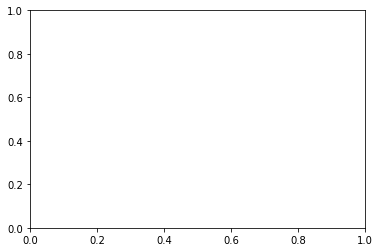

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
x_limit = [tankc[i][0] for i in range(len(tankc))]
y_limit = [tankc[i][1] for i in range(len(tankc))]
ax.set_xlim((0,max(x_limit)+3))
ax.set_ylim((0,max(y_limit)+3))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
# animation function. This is called sequentially
def animate(i):
    x = np.array(x_limit)

    y = np.array(y_limit)
    line.set_data(y, x)
    return (line,)
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
HTML(anim.to_html5_video())

30 2
1 2
4 5


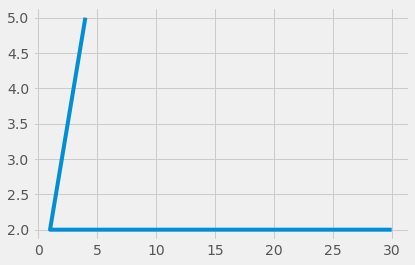

In [95]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style

style.use('fivethirtyeight')

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
z=[[30,2],[1,2],[4,5]]
def animate(i):
    #graph_data = open('example.txt','r').read()
    lines = z#graph_data.split('\n')
    xs = []
    ys = []
    for line in lines:
        if len(line) > 1:
            x, y = line[0],line[1]
            print(x,y)
            xs.append(float(x))
            ys.append(float(y))
    ax1.clear()
    ax1.plot(xs, ys)
ani = animation.FuncAnimation(fig, animate, interval=1000000)
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
print(dronec)
x = [tankc[i][0] for i in range(len(tankc))]
y = [tankc[i][1] for i in range(len(tankc))]
x1 = [dronec[i][0] for i in range(len(dronec))]
y1 = [dronec[i][1] for i in range(len(dronec))]
x2 = [droner[i][0] for i in range(len(droner))]
y2 = [droner[i][1] for i in range(len(droner))]


plt.scatter(x1,y1)
plt.scatter(x2,y2,color='red')
plt.show

NameError: name 'dronec' is not defined

In [6]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)   

from PIL import  Image,ImageDraw

img = uframes[20]
z = Image.fromarray(img)
z.show()
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
temp = model(x_1[0].reshape(1,3,100,100))[0].detach().numpy()
filename = "Marginalization_Simple-increased_channels-32-video-multiple/TD.txt"
file = open(filename, 'w')
file.write(str(model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()))
file.close()

In [14]:
import sys
np.set_printoptions(threshold=np.inf)
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)   

from PIL import  Image,ImageDraw

img = Image.open("frame/tank_frame0.jpg")
img =  cv2.resize(np.asarray(img),(100,100))
data3=[]
data3.append(np.array(np.transpose(np.asarray(img),(2,0,1)),dtype=np.float32))
y3 = np.array(data3)
x_1 = torch.from_numpy(y3)
temp = model(x_1[0].reshape(1,3,100,100))[0].detach().numpy()
filename = "Marginalization_Simple-increased_channels-32-video-multiple/tank.txt"
file = open(filename, 'w')
file.write(str(model(x_1[0].reshape(1,3,100, 100))[0].detach().numpy()))
file.close()